In [1]:
%matplotlib inline

In [2]:
# !TODO

# CMOD for HH and HV/VH - Hwang

# Ice from cross pol

# Svalbard/Barents Area Case Study

# Remove antenna pattern
# https://github.com/senbox-org/s1tbx/blob/master/s1tbx-op-calibration/src/main/java/org/esa/nest/gpf/ASARCalibrator.java

# Trimm the data by removing zero values from side rows and cols

# Read and calibrate SLC product

# Example from Fab (Chapron)
# s1a-s5-grd-hh-20140818t181248-20140818t181312-001998-001ef8-001-roughness
# https://mail.google.com/mail/u/0/#inbox/14961597bb0cef3c

In [3]:
from numpy import asarray, zeros, reshape, double, arange, ma, log10, diff, mean, flipud

In [4]:
import zipfile

import datetime

import matplotlib.pyplot as plt

from matplotlib.mlab import find
import xmltodict

from PIL import Image
import StringIO

from scipy.interpolate import RectBivariateSpline
from scipy.signal import wiener

import os

__author__   = 'Alexander Myasoedov'
__email__    = 'mag@rshu.ru'
__created__  = datetime.datetime(2014, 10, 28)
__modified__ = datetime.datetime(2014, 11, 13)
__version__  = "1.0"
__status__   = "Development"

In [5]:
from multiprocessing import cpu_count
numProcs = cpu_count()

In [6]:
from numpy import linspace, arange

def imresize(image, size):
    """
    Resizes coefficient arrays using bivariate spline approximation.
    """
    m, n = image.shape
    X = linspace(0, m - 1, size[0])
    Y = linspace(0, n - 1, size[1])
    kx, ky = min([m - 1, 3]), min([n - 1, 3])
    interp = RectBivariateSpline(
        arange(m), arange(n), image, kx=kx, ky=ky)
    resized = interp(X, Y)
    return resized

In [7]:
from math import atan

def windDirection(u, v):
    U = u.ravel()
    V = v.ravel()
    direction = zeros(size(U))
    for i in range(0, len(U)):
        if U[i] >= 0 and V[i] > 0: direction[i] = ((180 / pi) * atan(abs(U[i] / V[i])) + 180)
        if U[i] < 0 and V[i] > 0: direction[i] = (-(180 / pi) * atan(abs(U[i] / V[i])) + 180)
        if U[i] >= 0 and V[i] < 0: direction[i] = (-(180 / pi) * atan(abs(U[i] / V[i])) + 360)
        if U[i] < 0 and V[i] < 0: direction[i] = ((180 / pi) * atan(abs(U[i] / V[i])))
        if V[i] == 0 and U[i] > 0: direction[i] = 270
        if V[i] == 0 and U[i] < 0: direction[i] = 90
        if V[i] == 0 and U[i] == 0: direction[i] = 0
    return reshape(direction, v.shape)

In [8]:
# Using NCEP
from createMapsEtopo1 import findSubsetIndices
import pygrib

def ncepGFSmodel(startTime, lats_2, lons_2):
    """
    NCEP GFS model wind for givven time, lat/lon crop 
    """
    ncepGFSmodel = {} # empty dict for ncepGFSmodel

    iPath_wind = '/media/SOLabNFS2/store/model/ncep/gfs/'

    # find the ncep gfs filename to open from ASAR filename
    baseHour = floor((startTime.hour+3/2)/6)*6
    baseHour = min(18, baseHour)
    if startTime.hour-baseHour>1.5:
        forecastHour = 3
    else:
        forecastHour = 0

    if startTime <= datetime.datetime(2014, 8, 19):
        ncepFileName = 'gfs' + startTime.strftime("%Y%m%d") + '/gfs.t' + '%.2d' %(baseHour) + 'z.master.grbf' + '%.2d' %(forecastHour)

        grbs = pygrib.open(iPath_wind + ncepFileName)

        u_wind = None
        v_wind = None

        # wind contains u=u_wind.values[:], Lats=u_wind.latlons()[0], Lons=u_wind.latlons()[1]
        for idx, msg_info in enumerate(grbs.select()):
            if msg_info['short_name'] == '10u':
                u_wind = grbs.message(idx + 1)
            elif msg_info['short_name'] == '10v':
                v_wind = grbs.message(idx + 1)

        u = u_wind.values[:]
        v = v_wind.values[:]
        lats_wind = u_wind.latlons()[0]
        lons_wind = u_wind.latlons()[1]
    else:
        ncepFileName = 'gfs.' + startTime.strftime("%Y%m%d") + '%.2d' %(baseHour) + '/gfs.t' + '%.2d' %(baseHour) + 'z.master.grbf' + '%.2d' %(forecastHour) + '.10m.uv.grib2'

        grbs = pygrib.open(iPath_wind + ncepFileName)

        u_wind = grbs.message(1)
        v_wind = grbs.message(2)
        u = u_wind['values']
        v = v_wind['values']
        lats_wind = u_wind['latitudes']
        lons_wind = u_wind['longitudes']
        lons_wind = reshape(lons_wind, (lons_wind.shape[0]/720, 720))
        lats_wind = reshape(lats_wind, (lats_wind.shape[0]/720, 720))


    #Make sure the longitude is between -180.00 .. 179.9
    lons_wind = map(lambda x : (lons_wind.ravel()[x]+180)-int((lons_wind.ravel()[x]+180)/360)*360-180, range(0,lons_wind.size))
    lons_wind = reshape(lons_wind, lats_wind.shape)
    # plt.close('all')
    # plt.imshow(lons_wind)
    # plt.colorbar()

#     #Make sure the latitudes is between -90.00 .. 89.9, starting from North - positive
#     lats_wind = map(lambda x : (lats_wind.ravel()[x]+90)-int((lats_wind.ravel()[x]+90)/180)*180-90, xrange(0,lats_wind.size))
#     lats_wind = reshape(lats_wind, lons_wind.shape)
#     if lats_wind[0,0] < lats_wind[-1,-1]:
#         lats_wind = flipud(lats_wind)
#         u = flipud(u)
#         v = flipud(v)
#     plt.close('all')
#     plt.imshow(lats_wind)
#     plt.colorbar()


    # find subset
    res = findSubsetIndices(lats_2.min(),lats_2.max(),lons_2.min(),lons_2.max(),lats_wind[:,0],lons_wind[0,:])
    # expand subset by 1 pixel for better further pyresample
    res[0]=res[0]-2
    res[1]=res[1]+2
    res[2]=res[2]-2
    res[3]=res[3]+2

    # crop the data
    u = u[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    v = v[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    ncepGFSmodel['lats_wind'] = lats_wind[int(res[2]):int(res[3]),int(res[0]):int(res[1])]
    ncepGFSmodel['lons_wind'] = lons_wind[int(res[2]):int(res[3]),int(res[0]):int(res[1])]

    ncepGFSmodel['wind_dir'] = windDirection(u,v)
    ncepGFSmodel['wind_speed'] = sqrt(u**2 + v**2)

#     del u_wind, v_wind
    return ncepGFSmodel

In [9]:
def swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc', lonlim=(-180,180), latlim=(-90,90), ellps="WGS84", res=111.2e3, lat_ts=None, lat_0=None, lon_0=None):
    """
    Convert given swath coordinates to pyresample area definition.
    The arguments are standard for Proj:
    name
    proj
    lonlim
    latlim
    ellipsoid
    resolution(meters)
    lat_ts (latitude of true scale)
    lat_0,lon_0 is central point
    EXAMPLE:
    
    epsg3426 is the default one
    for epsg3413:
    swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=111.2e3, lat_ts=70, lat_0=90, lon_0=-45)
        
    """

    area_id = name.replace(" ", "_").lower()
    proj_id = area_id

    up    = min(latlim)
    down  = max(latlim)
    left  = min(lonlim)
    right = max(lonlim)
    
    if proj == 'eqc':
        p = Proj(proj=proj, llcrnrlat=up, urcrnrlat=down, llcrnrlon=left, urcrnrlon=right, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+llcrnrlat=' + str(up) + ' ' + \
             '+urcrnrlat=' + str(down) + ' ' + \
             '+llcrnrlon=' + str(left) + ' ' + \
             '+urcrnrlon=' + str(right) + ' ' + \
             '+ellps=' + str(ellps)
    elif lat_ts!=None and lat_0!=None:
        # lat_ts is latitude of true scale.
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, lat_ts=lat_ts, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+lat_ts=' + str(lat_ts) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0!=None and lat_0!=None and lat_ts==None:
        # lon_0,lat_0 is central point.
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)
    elif lon_0==None and lat_0==None and lat_ts==None:
        # lon_0,lat_0 is central point.
        lat_0 = (min(latlim) + max(latlim)) / 2
        lon_0 = (min(lonlim) + max(lonlim)) / 2
        p = Proj(proj=proj, lat_0=lat_0, lon_0=lon_0, ellps=ellps)
        proj4_args = '+proj=' + str(proj) + ' ' + \
             '+lat_0=' + str(lat_0) + ' ' + \
             '+lon_0=' + str(lon_0) + ' ' + \
             '+ellps=' + str(ellps)

    # area_extent defined as (x_min, y_min, x_max, y_max)
    left_ex1, up_ex1 = p(left, up)
    right_ex1, up_ex2 = p(right, up)
    left_ex2, down_ex1 = p(left, down)
    right_ex2, down_ex2 = p(right, down)

    area_extent = (min(left_ex1, left_ex2),
                   min(up_ex1, up_ex2),
                   max(right_ex1, right_ex2),
                   max(down_ex1, down_ex2))

    # минимум из всех координат X, Y, максимум из всех координат X, Y
    # Такой результат даёт правильный area_extent для 3413
    # При этом для 4326 area_extent остаётся неизменным
    # area_def_3413 = swath_area_def(name='Temporal SWATH EPSG Projection 3413', proj='stere', \
    #                                lonlim=(-180,180), latlim=(30,90), ellps="WGS84", res=1500, \
    #                                lat_ts=70, lat_0=90, lon_0=-45)
    # Area extent: (-5050747.263141337, 0.0, 0.0, 5050747.263141336)
    area_extent = (min(left_ex1, left_ex2, right_ex1, right_ex2),
                   min(up_ex1, up_ex2, down_ex1, down_ex2),
                   max(left_ex1, left_ex2, right_ex1, right_ex2),
                   max(up_ex1, up_ex2, down_ex1, down_ex2))

#     Using abs() to avoid negative numbers of coloumns/rows as for epsg3413 for example
    xsize = abs(int((area_extent[2] - area_extent[0]) / res[0]))
    ysize = abs(int((area_extent[3] - area_extent[1]) / res[1]))

    swath_area_def = pr.utils.get_area_def(area_id, name, proj_id, proj4_args, xsize, ysize, area_extent)

#     print swath_area_def

    return swath_area_def



In [10]:
# READ THE RAW_COUNTS from GRD image

def read_raw_counts(fn, fileLocation, polarization):


    # Note that For SLC images BitsPerSample=32 and for GRD BitsPerSample=16

    # im = Image.open(inpath + fileLocation['s1aiwgrd' + polarization])

    im = zf.read(fn[:-4] + '.SAFE' + fileLocation[fn.lower().replace("_","")[0:8] + polarization][1:])
    im = StringIO.StringIO(im) #Encode the raw data to be used by Image.open()
    im = Image.open(im)        #Open the image

    return asarray(im)

In [11]:
# READ the ANNOTATION

def read_anotation(fn, fileLocation, polarization):
    # open the fileLocation

    # annotation = open(inpath + fileLocation['products1aiwgrd' + polarization], "r") # Open a file in read-only mode
    # annotation = annotation.read() # read the file object

    annotation = zf.read(fn[:-4] + '.SAFE' + fileLocation['product' + fn.lower().replace("_","")[0:8] + polarization][1:])
    annotation = xmltodict.parse(annotation) # Parse the read document string

    # get geolocationGrid parameters from the Annotation Data Set Records (ADSR)
    # preallocate variables
    GEOgrid = {} # empty dict for GEOgrids

    geolocationGridPointList = annotation['product']['geolocationGrid']['geolocationGridPointList']
    GEOgrid['lats']  = zeros( ( int(geolocationGridPointList['@count']), 1) )
    GEOgrid['lons']  = zeros( GEOgrid['lats'].shape )
    GEOgrid['line']  = zeros( GEOgrid['lats'].shape, dtype=int )
    GEOgrid['pixel'] = zeros( GEOgrid['lats'].shape, dtype=int )
    GEOgrid['incidenceAngle'] = zeros( GEOgrid['lats'].shape )

    # read Geolocation grid points
    for n in range(int(geolocationGridPointList['@count'])):
        GEOgrid['lats'][n]  = float(geolocationGridPointList['geolocationGridPoint'][n]['latitude'])
        GEOgrid['lons'][n]  = float(geolocationGridPointList['geolocationGridPoint'][n]['longitude'])
        GEOgrid['line'][n]  = int(geolocationGridPointList['geolocationGridPoint'][n]['line'])
        GEOgrid['pixel'][n] = int(geolocationGridPointList['geolocationGridPoint'][n]['pixel'])
        GEOgrid['incidenceAngle'][n] = float(geolocationGridPointList['geolocationGridPoint'][n]['incidenceAngle'])


    # find zero pixel to rehape grid points to array
    ind = find(GEOgrid['pixel'] == 0)
    GEOgrid['pixel'] = reshape(GEOgrid['pixel'], (ind.size, GEOgrid['lats'].size/ind.size))
    GEOgrid['line']  = reshape(GEOgrid['line'], (ind.size, GEOgrid['lats'].size/ind.size))
    GEOgrid['lats']  = reshape(GEOgrid['lats'], (ind.size, GEOgrid['lats'].size/ind.size))
    GEOgrid['lons']  = reshape(GEOgrid['lons'], (ind.size, GEOgrid['lats'].size/ind.size))
    GEOgrid['incidenceAngle'] = reshape(GEOgrid['incidenceAngle'], (ind.size, GEOgrid['lats'].size/ind.size))
    
    return GEOgrid

In [12]:
# READ the CALIBRATION LUTs

def read_clbrtn_luts(fn, fileLocation, polarization):
    # The calibration data set contains calibration information
    # and the beta nought, sigma nought, gamma and digital
    # number (DN) Look-up Tables (LUT)s that can be used for
    # absolute product calibration.

    # We take only the calibrationVector record
    # This record holds the calibration vectors and associated fields required to
    # derive radiometrically calibrated imagery from the image MDS.

    # open the fileLocation

    # calibration = open(inpath + fileLocation['calibrations1aiwgrd' + polarization], "r") # Open a file in read-only mode
    # calibration = calibration.read() # read the file object

    calibration = zf.read(fn[:-4] + '.SAFE' + fileLocation['calibration' + fn.lower().replace("_","")[0:8] + polarization][1:])
    calibration = xmltodict.parse(calibration) # Parse the read document string

    calibrationVectorList = calibration['calibration']['calibrationVectorList']

    cLUTs = {} # empty dict for CALIBRATION LUTs

    cLUTs['line']  = zeros( ( int(calibrationVectorList['@count']), 1), dtype=int )
    cLUTs['pixel'] = zeros( (cLUTs['line'] .shape[0], int(calibrationVectorList['calibrationVector'][0]['pixel']['@count'])), dtype=int )
    cLUTs['sigmaNought']  = zeros( cLUTs['pixel'].shape, dtype=float)

    # read Calibration Vector points
    for n in range(int(calibrationVectorList['@count'])):
        cLUTs['line'][n] = int(calibrationVectorList['calibrationVector'][n]['line'])
        pixel_     = calibrationVectorList['calibrationVector'][0]['pixel']['#text']
        cLUTs['pixel'][n,:] = asarray(pixel_.split(' '), dtype=int)
        sigmaNought_     = calibrationVectorList['calibrationVector'][0]['sigmaNought']['#text']
        cLUTs['sigmaNought'][n,:] = asarray(sigmaNought_.split(' '), dtype=float)

    return cLUTs

In [13]:
# READ the NOISE LUTs

def read_noise_luts(fn, fileLocation, polarization):
    # The L1 Noise ADS provides a LUT – with values provided in linear power – 
    # that can be used to derive calibrated noise profiles which match the calibrated GRD data.

    # open the fileLocation

    noise = zf.read(fn[:-4] + '.SAFE' + fileLocation['noise' + fn.lower().replace("_","")[0:8] + polarization][1:])
    noise = xmltodict.parse(noise) # Parse the read document string

    noiseVectorList = noise['noise']['noiseVectorList']

    nLUTs = {} # empty dict for NOISE LUTs

    nLUTs['line']  = zeros( ( int(noiseVectorList['@count']), 1), dtype=int )
    nLUTs['pixel'] = zeros( (nLUTs['line'] .shape[0], int(noiseVectorList['noiseVector'][0]['pixel']['@count'])), dtype=int )
    nLUTs['noiseLut']  = zeros( nLUTs['pixel'].shape, dtype=float)

    # read Calibration Vector points
    for n in range(int(noiseVectorList['@count'])):
        nLUTs['line'][n] = int(noiseVectorList['noiseVector'][n]['line'])
        pixel_     = noiseVectorList['noiseVector'][0]['pixel']['#text']
        nLUTs['pixel'][n,:] = asarray(pixel_.split(' '), dtype=int)
        noiseLut_     = noiseVectorList['noiseVector'][0]['noiseLut']['#text']
        nLUTs['noiseLut'][n,:] = asarray(noiseLut_.split(' '), dtype=float)

    return nLUTs

In [14]:
# import os

# inpath = '/media/SOLabNFS2/tmp/sentinel-1/'

# fileNameList = []
# for _dir, sub_dir, _files in os.walk(inpath):
#     for fileName in _files:
#         if fileName.startswith('S1A') and fileName.endswith('.zip') and fileName.find('RAW')==-1:
#             fileNameList.append(fileName)

In [15]:
# def xml2geo(self):
#         """
#         Reading geolocation grids from attributes
#         One may note that Ground Range, Multi-Look, Detected (GRD) products
#         lie in the ground range by azimuth surface,
#         with image coordinates oriented along ground range and flight direction.
#         Slant Range, Single-Look Complex (SLC) products
#         are images in the slant range by azimuth imaging plane,
#         in the image plane of satellite data acquisition.
#         """

# inpath = '/media/SOLabNFS2/tmp/sentinel-1/S1A_IW_GRDH_1SDV_20141004T155619_20141004T155644_002682_002FE5_BE58.SAFE/'
inpath = '/media/SOLabNFS2/tmp/sentinel-1/'

# READ THE MANIFEST - top level

# manifest = open(inpath + "manifest.safe", "r") # Open a file in read-only mode
# manifest = manifest.read()      # read the file object

# open zip file without extraction
# finnGulf
# fn = 'S1A_IW_GRDH_1SDV_20141004T155619_20141004T155644_002682_002FE5_BE58.zip'

# Svalbard-Barents
inpath = '/media/SOLabNFS2/tmp/sentinel-1/Svalbard-Barents/'
fileNameList = ['S1A_EW_GRDH_1SDH_20141003T071321_20141003T071421_002662_002F6B_AFCF.zip',
                 'S1A_EW_GRDH_1SDH_20141003T071221_20141003T071321_002662_002F6B_0F56.zip',
                 'S1A_EW_GRDH_1SDH_20141003T071117_20141003T071221_002662_002F6B_CAFE.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061601_20141004T061701_002676_002FBD_3300.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061701_20141004T061800_002676_002FBD_EF64.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061601_20141004T061701_002676_002FBD_B433.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061357_20141004T061501_002676_002FBD_A7E4.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061701_20141004T061800_002676_002FBD_89ED.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061501_20141004T061601_002676_002FBD_A842.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061501_20141004T061601_002676_002FBD_4B66.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061357_20141004T061501_002676_002FBD_D530.zip',
                 'S1A_EW_GRDM_1SDH_20141003T151915_20141003T152019_002667_002F88_B77B.zip',
                 'S1A_EW_GRDM_1SDH_20141003T152119_20141003T152229_002667_002F88_1BCA.zip',
                 'S1A_EW_GRDH_1SDH_20141003T152119_20141003T152229_002667_002F88_8003.zip',
                 'S1A_EW_GRDH_1SDH_20141003T152019_20141003T152119_002667_002F88_9106.zip',
                 'S1A_EW_GRDH_1SDH_20141003T151915_20141003T152019_002667_002F88_C200.zip',
                 'S1A_EW_GRDH_1SDH_20141003T134257_20141003T134338_002666_002F83_5FD6.zip',
                 'S1A_EW_GRDH_1SDH_20141003T134057_20141003T134157_002666_002F83_7D9C.zip',
                 'S1A_EW_GRDH_1SDH_20141003T134157_20141003T134257_002666_002F83_30DE.zip',
                 'S1A_EW_GRDH_1SDH_20141003T133957_20141003T134057_002666_002F83_0BE7.zip']

# inpath = '/media/SOLabNFS2/tmp/sentinel-1/'
# fileNameList = ['S1A_IW_GRDH_1SDV_20141004T155619_20141004T155644_002682_002FE5_BE58.zip']


fn = fileNameList[-1]

zf = zipfile.ZipFile(inpath+fn, 'r')

manifest = zf.read(fn[:-4] + '.SAFE/manifest.safe')
manifest = xmltodict.parse(manifest) # Parse the read document string

# we have different XML/GeoTIFF fileLocations for vv-vh (or hh-hv) products, respectively
# create new dict with file paths to the fileLocations
fileLocation = {} # empty dict
dataObject = manifest['xfdu:XFDU']['dataObjectSection']['dataObject']
for n in range(len(dataObject)):
    if len(dataObject[n]['@ID']) > 45:
        k = dataObject[n]['@ID'][0:-45] # get the new key from @ID
    else:
        k = dataObject[n]['@ID'] # get the new key from @ID
    v = str(dataObject[n]['byteStream']['fileLocation']['@href']) # get the dict.value
    fileLocation[k] = v # assign to new dict
#     locals()['fileLocation_'+k]=v # create local variable from 'fileLocation' dict.key


In [16]:
# Get the productType/polarization

metadataObject = manifest['xfdu:XFDU']['metadataSection']['metadataObject']
for n in range(len(metadataObject)):
    if metadataObject[n]['@ID'] == 'generalProductInformation':
        productType = metadataObject[n]['metadataWrap']['xmlData']['s1sarl1:standAloneProductInformation']['s1sarl1:productType']
        transmitterReceiverPolarisation = metadataObject[n]['metadataWrap']['xmlData']['s1sarl1:standAloneProductInformation']['s1sarl1:transmitterReceiverPolarisation']

polarization = []
for p in range(0,len(transmitterReceiverPolarisation[0].lower())):
    polarization.append(transmitterReceiverPolarisation[p].lower())
print "Available polarizations: \'%s\'" %polarization

Available polarizations: '[u'hh', u'hv']'


In [17]:
# %%timeit -n 1 -r 1

raw_counts = {}
lats_2 = {}
lons_2 = {}
incidenceAngle_2 = {}
sigmaNought_2 = {}
noiseLut_2 = {}
sigma0 = {}

for p in polarization:
    print "Reading raw_counts: \'%s\' polarization" %p

    # READ THE RAW_COUNTS from GRD image
    raw_counts[p] = read_raw_counts(fn, fileLocation, p)

# READ the ANNOTATION
GEOgrid = read_anotation(fn, fileLocation, polarization[0])

# READ the CALIBRATION LUTs
cLUTs = read_clbrtn_luts(fn, fileLocation, polarization[0])

# READ the NOISE LUTs
nLUTs = read_noise_luts(fn, fileLocation, polarization[0])

#  ----------------------------------
# INTERPOLATE DATA
# Interpolate Geolocation grid points and calibration LUTs onto grid of raw_counts.shape

# Serial Processing

# Serial loop is faster than the Parallel Loop (see appropriate ipnb file)
# 1 loops, best of 1: 31.5 s per loop
# %%timeit -n 1 -r 1

# create new grid of raw_counts shape
line_2 = arange(raw_counts[p].shape[0])
pixel_2 = arange(raw_counts[p].shape[1])

# Interpolate onto a new grid
lats_2 = RectBivariateSpline(GEOgrid['line'][:,0], GEOgrid['pixel'][0,:], GEOgrid['lats'], kx=2, ky=2)(line_2, pixel_2)
lons_2 = RectBivariateSpline(GEOgrid['line'][:,0], GEOgrid['pixel'][0,:], GEOgrid['lons'], kx=2, ky=2)(line_2, pixel_2)


for p in polarization:
    print "Interpolating LUTs: \'%s\' polarization" %p

    # interpolate incidenceAngle
    incidenceAngle_2[p] = RectBivariateSpline(GEOgrid['line'][:,0], GEOgrid['pixel'][0,:], GEOgrid['incidenceAngle'], kx=2, ky=2)(line_2, pixel_2)

    # interpolate sigmaNought
    sigmaNought_2[p] = RectBivariateSpline(cLUTs['line'][:,0], cLUTs['pixel'][0,:], cLUTs['sigmaNought'], kx=2, ky=2)(line_2, pixel_2)

    # interpolate noiseLut
    noiseLut_2[p] = RectBivariateSpline(nLUTs['line'][:,0], nLUTs['pixel'][0,:], nLUTs['noiseLut'], kx=2, ky=2)(line_2, pixel_2)

    # Apply Calibration, remove the thermal noise estimation and Convert to Intensity
    sigma0[p] = ( double(raw_counts[p])**2 - noiseLut_2[p] )/sigmaNought_2[p]**2


Reading raw_counts: 'hh' polarization
Reading raw_counts: 'hv' polarization
Interpolating LUTs: 'hh' polarization
Interpolating LUTs: 'hv' polarization


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2221: DecompressionBombWarning: Image size (267557682 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [18]:
scale = 10

sigma0w = {}
roughness = {}

print "Scale set to: \'%s\' " %scale

for p in polarization:
    print "Filtering Image: \'%s\' polarization" %p
    
    # filter the image
    sigma0w[p] = wiener(sigma0[p][::scale,::scale], mysize=(7,7), noise=None)
#     sigma0w[p] = sigma0[p]

# Close ZIP-file
zf.close()

Scale set to: '10' 
Filtering Image: 'hh' polarization
Filtering Image: 'hv' polarization


In [19]:
# S1 Pixel resolution
# we use pxlResSAR for further GSHHS rasterizing and reprojecting data with pyresample

lonlim = (lons_2[::scale,::scale].min(),lons_2[::scale,::scale].max())
latlim = (lats_2[::scale,::scale].min(),lats_2[::scale,::scale].max())

# enlarge lonlims for cropping a bit larger area for masking
lonlimGSHHS = (lonlim[0]-1.0, lonlim[1]+1.0)
latlimGSHHS = (latlim[0]-1.0, latlim[1]+1.0)


# Get first guess pixel resolution
import distancelib
pxlResSARm  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                     lons_2[::scale,::scale], \
                                                     lons_2[::scale,::scale].shape, 'km'))*1e3
pxlResSARdeg  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                       lons_2[::scale,::scale], \
                                                       lons_2[::scale,::scale].shape, 'deg'))

print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)

S1 cell resolution, [ 0.0022796   0.00223499] deg
S1 cell resolution, [ 253.30888834  248.35185871] m


In [20]:
import pyresample as pr
from pyproj import Proj

# Define areas with pyresample
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])

area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=pxlResSARm)

In [21]:
# Get the SAR pixel resolution from the area_def for further identical shapes
up    = min(latlimGSHHS)
down  = max(latlimGSHHS)
left  = min(lonlimGSHHS)
right = max(lonlimGSHHS)
area_extent_deg = (left, down, right, up)

area_extent_deg_shape = area_def_4326.shape

pxlResSARdeg = asarray( (abs(area_extent_deg[2] - area_extent_deg[0]) / float(area_extent_deg_shape[1]), \
                abs(area_extent_deg[3] - area_extent_deg[1]) / float(area_extent_deg_shape[0])) )

pxlResSARm = asarray( (area_def_4326.pixel_size_x, area_def_4326.pixel_size_y) )
print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)


S1 cell resolution, [ 0.00227558  0.00223128] deg
S1 cell resolution, [ 253.3168363   248.38501708] m


In [22]:
# Apply Mask from GSHHS

import gshhs_rasterize
reload(gshhs_rasterize)

# ESRI shapefile containing land polygons
shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'

# reproject GSHHS onto S1 grid before calculations
print "Rasterizing Land Mask"
mask_arr_4326 = gshhs_rasterize.gshhs_rasterize_4326(lonlimGSHHS, latlimGSHHS, \
                                     pxlResSARdeg, area_def_4326.shape, True, \
                                     shapefile)

Rasterizing Land Mask


In [23]:
mask_arr_swath = pr.kd_tree.resample_nearest(area_def_4326, mask_arr_4326, swath_def, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [24]:
print area_def_4326.shape, mask_arr_4326.shape
print mask_arr_swath.shape, sigma0w[p].shape, swath_def.shape

(2933, 8100) (2933, 8100)
(1599, 1674) (1599, 1674) (1599, 1674)


In [25]:
# Nice Image (Roughness)

sigma0wAvg = {}
roughnessNrmlzd = {}

for p in polarization:
    print "Nice Image: \'%s\' polarization" %p

    roughness[p] = ma.masked_where(mask_arr_swath, sigma0w[p])

    sigma0wAvg[p] = ma.median(roughness[p], axis=0)

    roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]

Nice Image: 'hh' polarization
Nice Image: 'hv' polarization


In [26]:
import os
# Save images
oPath = '/home/mag/tmp/'

for p in polarization:
    print "Saving Image: \'%s\' polarization" %p
    plt.close('all')
    oFileName = os.path.join(oPath, fn[:-3]+p+'_bone_r.png')
    plt.imsave(oFileName, roughnessNrmlzd[p], vmin=-1, vmax=1, cmap=plt.cm.bone_r)
    oFileName = os.path.join(oPath, fn[:-3]+p+'_RdBu_r.png')
    plt.imsave(oFileName, roughnessNrmlzd[p], vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)

Saving Image: 'hh' polarization
Saving Image: 'hv' polarization


In [27]:
# Reproject

roughness_4326 = {}

for p in polarization:
    print "Reprojecting Image: \'%s\' polarization" %p

    roughness_4326[p] = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd[p], area_def_4326, \
                                                 radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

Reprojecting Image: 'hh' polarization
Reprojecting Image: 'hv' polarization


In [28]:
import os
# Save images
oPath = '/home/mag/tmp/'

for p in polarization:
    print "Saving Projected Image: \'%s\' polarization" %p
    plt.close('all')
    oFileName = os.path.join(oPath+'proj/', fn[:-3]+p+'_4326_bone_r.png')
    plt.imsave(oFileName, roughness_4326[p], vmin=-1, vmax=1, cmap=plt.cm.bone_r)
    oFileName = os.path.join(oPath+'proj/', fn[:-3]+p+'_4326_RdBu_r.png')
    plt.imsave(oFileName, roughness_4326[p], vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)

Saving Projected Image: 'hh' polarization
Saving Projected Image: 'hv' polarization


In [29]:
p = 'hv'

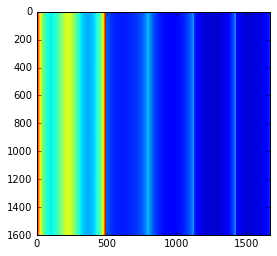

In [30]:
plt.close('all')
plt.imshow(noiseLut_2[p][::scale,::scale])

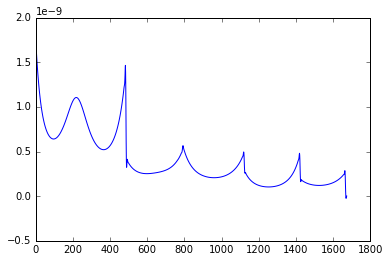

In [31]:
plt.close('all')
plt.figure()
plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0), 'b')
# plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0)*1e6, 'r')
plt.show()

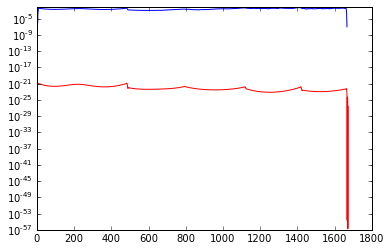

In [32]:
plt.close('all')
plt.semilogy( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2)/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.hold(True)
plt.semilogy( noiseLut_2[p][::scale,::scale].mean(axis=0)**2/sigmaNought_2[p][::scale,::scale].mean(axis=0) , 'r')
plt.axes()
plt.show()

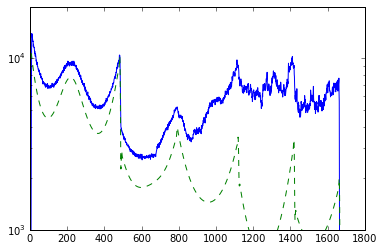

In [33]:
plt.close('all')
plt.semilogy( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 )
plt.semilogy( noiseLut_2[p][::scale,::scale].mean(axis=0)*7e12, '--' )
plt.ylim(1e3,2e4)
plt.show()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from IPython.kernel.zmq import kernelapp as app


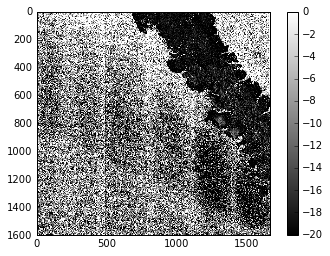

In [34]:
plt.close('all')
plt.imshow( 10*log10( (double(raw_counts[p][::scale,::scale])**2 - noiseLut_2[p][::scale,::scale]*1e13 )/sigmaNought_2[p][::scale,::scale]**2),
           vmin=-20, vmax=0)
plt.gray()
plt.colorbar()
plt.show()

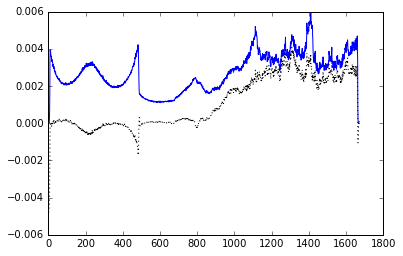

In [35]:
# sigma0[p] = ( double(raw_counts[p])**2 - noiseLut_2[p] )/sigmaNought_2[p]**2

plt.close('all')
plt.plot( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 - noiseLut_2[p][::scale,::scale].mean(axis=0)     )/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.plot( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 - noiseLut_2[p][::scale,::scale].mean(axis=0)*1e13 )/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2, 'k:')
# plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0)*1e13, 'r')
plt.show()

In [36]:
# Try to split the image into several parts and normalize each part to remove the scalloping effect
# which is still visible even after ESA applies the TOPSAR technique
# https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/acquisition-modes/interferometric-wide-swath

In [37]:
# From https://gist.github.com/endolith/250860

from numpy import NaN, Inf, arange, isscalar, asarray, array
 
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
 
    return array(maxtab), array(mintab)

In [38]:
# Find the peaks value index to split the image in several parts
# NB! We use sigma0 data for peaks not the LUTs, as the peaks in data and LUTs are a bit different, We believe the data itself, not the LUTs
# First guess number of peaks calculated from LUTs
from scipy.signal import argrelmax
nsLutIndLen = len(argrelmax(noiseLut_2[p][::scale,::scale].mean(axis=0), order=10, mode='wrap')[0])
#  Loop is done comparing vector to some threshold value until peaks are found
for ii in xrange(1,500,2):
    maxtab = peakdet(sigma0wAvg[p], 1e-6*ii)[0]
#     print len(maxtab[:,0])
    if len(maxtab[:,0]) == nsLutIndLen:
        break
sgmPeakInd = maxtab[:,0]

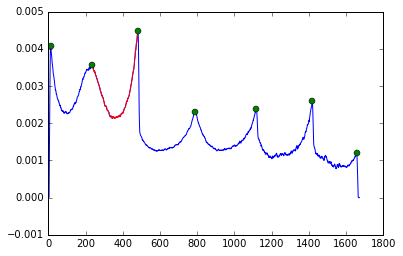

In [39]:
plt.close('all')
plt.plot(sigma0wAvg[p])
plt.hold(True)
plt.plot(arange(sgmPeakInd[1],sgmPeakInd[2]),sigma0wAvg[p][sgmPeakInd[1]:sgmPeakInd[2]], 'r')
plt.plot(maxtab[:,0], maxtab[:,1], 'go')
plt.show()

In [40]:
rghns1 = roughness[p][0:900,sgmPeakInd[1]:sgmPeakInd[2]]
sgmAvg1 = rghns1.mean(axis=1)
rghnsNrmlzd = (rghns1.T-sgmAvg1)/sgmAvg1
rghnsNrmlzd = rghnsNrmlzd.T

In [41]:
print argrelmax(sgmAvg1, order=30, mode='wrap')
print diff(argrelmax(sgmAvg1, order=30, mode='wrap'))
print '\n'

from scipy.signal import argrelmin
print argrelmin(sgmAvg1, order=30, mode='wrap')
print diff(argrelmin(sgmAvg1, order=30, mode='wrap'))

print mean(diff(argrelmax(sgmAvg1, order=30, mode='wrap')))
print mean(diff(argrelmin(sgmAvg1, order=30, mode='wrap'))[0,1:-1])


(array([ 79, 161, 236, 329, 403, 492, 563, 640, 731, 810, 885]),)
[[82 75 93 74 89 71 77 91 79 75]]


(array([  0,  44, 115, 187, 279, 354, 446, 523, 599, 678, 753, 856]),)
[[ 44  71  72  92  75  92  77  76  79  75 103]]
80.6
78.7777777778


In [42]:
print peakdet(sgmAvg1, 2e-4)[0][:,0]
print diff(peakdet(sgmAvg1, 2e-4)[0][:,0])
mean(diff(peakdet(sgmAvg1, 2e-4)[0][:,0]))

[   3.   79.  161.  236.  329.  403.  492.  563.  640.  731.  810.  885.]
[ 76.  82.  75.  93.  74.  89.  71.  77.  91.  79.  75.]


80.181818181818187

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


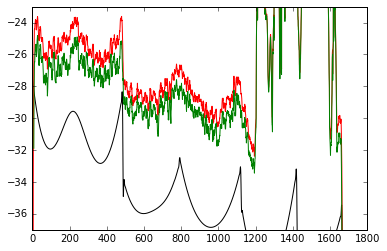

In [43]:
plt.close('all')
# plt.plot(3*log10(noiseLut_2[p][::scale,::scale][600,:]))
plt.plot(10*log10(noiseLut_2[p][::scale,::scale][600,:]*1e6), 'k')
# plt.plot(10*log10(noiseLut_2[p][::scale,::scale][600,:]))
plt.hold(True)
plt.plot(10*log10(sigma0w[p][600,:]), 'r')
plt.plot(10*log10(sigma0w[p][600,:]-noiseLut_2[p][::scale,::scale][600,:]*1e6), 'g')
# plt.ylim((-110,-23))
plt.ylim((-37,-23))
plt.show()

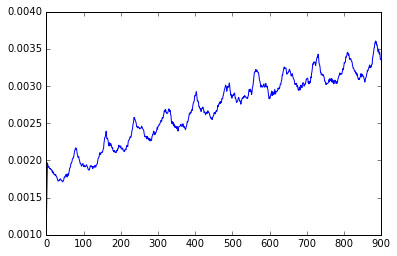

In [44]:
plt.close('all')
plt.plot(sgmAvg1)
# plt.hold(True)
# plt.plot(maxtab[:,0], maxtab[:,1], 'go')
plt.show()

In [45]:
from scipy import fftpack

# Take the fourier transform of the image.
f1 = fftpack.fft(sgmAvg1)

# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 1D fourier transformed image.
fshift = fftpack.fftshift( f1 )

# Calculate a 1D power spectrum
psd1D = abs( fshift )**2

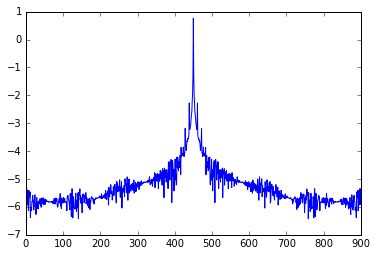

In [46]:
plt.close('all')
plt.plot(log10( psd1D ))
plt.show()

In [47]:
fftShiftInd = peakdet(psd1D, 2e-4)[0][:,0]
print fftShiftInd

[ 428.  439.  450.  461.  472.]


In [48]:
# remove the low frequencies by masking with a rectangular window
# High Pass Filter (HPF)
# rows, cols = noiseLut_2[p][::scale,::scale].shape
# crow,ccol = rows/2 , cols/2
# fshift[crow-10:crow-9, ccol-10:ccol+10] = 0

fshiftFiltered = fshift

fftShiftInd = peakdet(psd1D, 2e-4)[0][:,0]
for i in range(0,len(fftShiftInd)/2):
    fshiftFiltered[fftShiftInd[i]]=0
for i in range(len(fftShiftInd)/2+1,len(fftShiftInd)):
    fshiftFiltered[fftShiftInd[i]]=0
    
# fshiftFiltered[fftShiftInd[0]]=0
# fshiftFiltered[fftShiftInd[1]]=0
# fshiftFiltered[fftShiftInd[3]]=0
# fshiftFiltered[fftShiftInd[4]]=0

# Calculate a 1D power spectrum
psd1DFiltered = abs( fshiftFiltered )**2

# shift back (we shifted the center before)
f_ishift = fftpack.ifftshift(fshiftFiltered)

# inverse fft to get the image back
img_back = fftpack.ifft(f_ishift)
img_back = abs(img_back)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


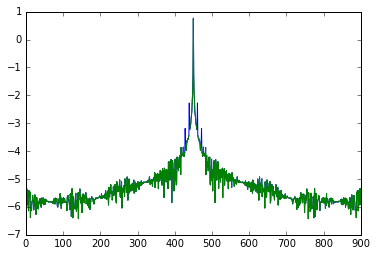

In [49]:
plt.close('all')
plt.plot(log10( psd1D ))
plt.hold(True)
plt.plot(log10( psd1DFiltered ))
plt.show()

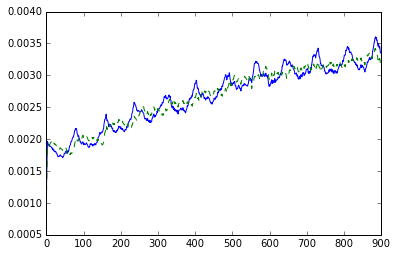

In [50]:
plt.close('all')
plt.plot(sgmAvg1)
plt.hold(True)
plt.plot(img_back, 'g--')
plt.show()

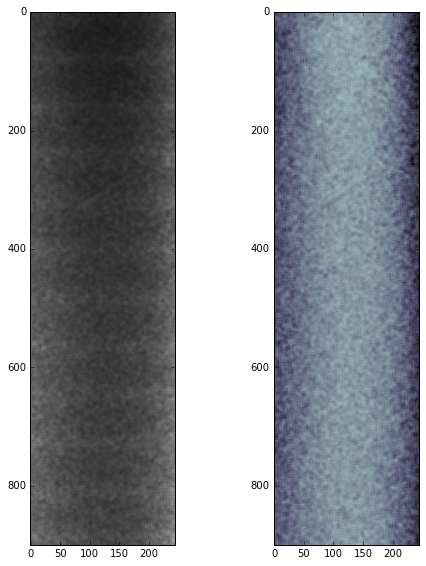

In [51]:
plt.close('all')
plt.figure(figsize=(8,32/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(rghns1, vmin=0, vmax=0.01)
plt.gray()
plt.subplot(122)
plt.imshow(rghnsNrmlzd, vmin=-1, vmax=1)
# plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()

plt.set_cmap('bone_r')
plt.show()

In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('magican', '5di4fue0lf')

noiseLutInd = Scatter(
        y=sigma0wAvg[p],
        mode='markers',
        marker=Marker(
            color='red',
            symbol='square'
        )
    )
data = Data([noiseLutInd])

# (3) Make Figure object
fig = Figure(data=data)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='noiseLutInd')
# plot_url = py.plot(fig, filename='noiseLutInd')

In [64]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('magican', '5di4fue0lf')

data = Data([
    Heatmap(
        z=flipud(roughnessNrmlzd['hh'][::10,::10]),
        colorscale='Greys',
        zauto=False,
        zmin=-1,
        zmax=1
    )
])

layout = Layout(
    autosize=True,
#     autosize=False,
#     width=roughnessNrmlzd['hh'].shape[1]/3,
#     height=roughnessNrmlzd['hh'].shape[0]/3,
)

# (3) Make Figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='roughnessNrmlzd')
# plot_url = py.plot(fig, filename='noiseLutInd')

In [ ]:
def ntrctv_imshow(data, FixedColor=False, vmi=-1., vma=1.):
    if FixedColor==False:
        imshow(data)
        colorbar()
    else:
        imshow(data, vmin=vm, vmax=vma)
        colorbar()

In [67]:
%matplotlib qt
plt.close('all')
mpl_fig_obj= plt.figure()
plt.imshow(roughnessNrmlzd['hh'], vmin=-1, vmax=1)
plt.set_cmap('bone_r')
plt.colorbar()

In [ ]:
plt.close('all')
plt.imshow(incidenceAngle_2[p][::scale,::scale])

In [ ]:
plt.close('all')
plt.plot(sigma0wAvg[p])
plt.plot(sigma0w[p].mean(axis=0), 'g')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.imshow(roughness[p], vmin=0, vmax=0.01)
# plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
# plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()
plt.colorbar()
plt.title(p)
plt.subplot(122)
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.gray()
plt.colorbar()
plt.title(p + ' Nrmlzd')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
# plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(131)
plt.imshow(10*log10(sigma0w[polarization[0]]), vmin=-20, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[0])
plt.subplot(132)
plt.imshow(10*log10(sigma0w[polarization[1]]), vmin=-30, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[1])
# plt.subplot(133)
# plt.imshow(roughness[polarization[0]][::scale,::scale], vmin=0, vmax=roughness[polarization[0]].mean())
# plt.gray()
# plt.colorbar()
# plt.title(polarization[0])

In [ ]:
# Adding Model wind

startTime = datetime.datetime.strptime(\
                              manifest['xfdu:XFDU']['metadataSection']['metadataObject'][12]\
                              ['metadataWrap']['xmlData']['safe:acquisitionPeriod']['safe:startTime'],\
                              "%Y-%m-%dT%H:%M:%S.%f")

ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(ncepGFSmodelWind['wind_speed'])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(ncepGFSmodelWind['wind_dir'])
plt.jet()
plt.colorbar()


In [ ]:
# plt.close('all')
# plt.figure(figsize=(16,4))
# plt.subplot(121)
# plt.imshow(ncepGFSmodelWind['lats_wind'])
# plt.jet()
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(ncepGFSmodelWind['lons_wind'])
# plt.jet()
# plt.colorbar()

In [ ]:
# plt.close('all')
# plt.plot(ncepGFSmodelWind['lons_wind'][0,:])
# plt.plot(ncepGFSmodelWind['lats_wind'][:,0])

In [ ]:
# Reprojecting data

import distancelib

# Pixel resolution
# we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
                                                    ncepGFSmodelWind['lons_wind'], \
                                                    ncepGFSmodelWind['lons_wind'].shape, 'km'))
# pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3

# Note pxlResWind is in KM, multiply by 1e3 for meters
print "S1 cell resolution, %s m"  % pxlResSARm
print "Wind cell resolution, %s km" % pxlResWind

In [ ]:
from scipy.interpolate import RectSphereBivariateSpline

def ncepGFSmodel2swath(lats, lons, data, lats_2, lons_2):

    func = RectSphereBivariateSpline(lats, lons, data)
    data_2 = func.ev(lats_2.ravel()*pi/180, \
                     lons_2.ravel()*pi/180)\
                     .reshape(lats_2.shape)
    return data_2


In [ ]:
# reproject NCEP onto S1 grid before calculations
# Using RectSphereBivariateSpline - Bivariate spline approximation over a rectangular mesh on a sphere
# as it is much more efficiant for full resolution
# as well as smoothes nicely the image

# We don't want to work with full res wind so scaling the image for about 100m resolution
# Adjust scale to get appropriate value
scale = 10

lts = flipud(ncepGFSmodelWind['lats_wind'])[:,0]*pi/180
lns = ncepGFSmodelWind['lons_wind'][0,:]*pi/180
data = flipud(ncepGFSmodelWind['wind_speed'])
data2 = flipud(ncepGFSmodelWind['wind_dir'])

lts_2 = lats_2[::scale,::scale]
lns_2 = lons_2[::scale,::scale]

wind_speed_model_swath = ncepGFSmodel2swath(lts, lns, data, lts_2, lns_2)
wind_dir_model_swath   = ncepGFSmodel2swath(lts, lns, data2, lts_2, lns_2)

del data, data2
    
pxlResWindSwath = asarray(distancelib.getPixelResolution(lts_2, \
                                                    lns_2, \
                                                    lns_2.shape, 'km'))
print "Interpolated Wind cell resolution, %s km" % pxlResWindSwath


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath[::33,::33])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_dir_model_swath[::33,::33])
plt.jet()
plt.colorbar()

In [ ]:
# calculate bearing from initial lats/lons for further wind calculation
# Taking initial values as bearing is more accurate after interpolation than vice versa
bearing = zeros((GEOgrid['lons'].shape[0]-1,GEOgrid['lons'].shape[1]))

for n in range(0,GEOgrid['lons'].shape[1]):
    col = ([GEOgrid['lats'][:-1,n], GEOgrid['lons'][:-1,n]], [GEOgrid['lats'][1:,n], GEOgrid['lons'][1:,n]])
    for m in range(0,GEOgrid['lons'].shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
bearing_2 = imresize(bearing, wind_dir_model_swath.shape)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.imshow(bearing_2)
plt.jet()
plt.colorbar()

In [ ]:
# # Wind Speed

# windSpeed = {}

# # the C-2PO (C-band Cross-Polarized Ocean) model
# # B. Zhang and W. Perrie, Cross-polarized synthetic aperture radar:
# # A new potential measurement technique for hurricanes, Bull. Amer. Meteor. Soc., pp. 531-541, 2012.
# if 'vh' in polarization:
#     windSpeed['vh'] = (10*log10(sigma0w['vh']) + 35.652)/0.58
# if 'hv' in polarization:
#     windSpeed['hv'] = (10*log10(sigma0w['hv']) + 35.652)/0.58

# # convert the signal measured in HH into VV polarization before using a GMF from the CMOD family
# if 'hh' in polarization:
#     alpha=1 # for Sentinel Toolbox alpha=1, initially it was 0.6
#     sigma0w['hh2vv'] = sigma0w['hh']*(1+2*tan(incidenceAngle_2['hh'])**2)**2/(1+alpha*tan(incidenceAngle_2['hh'])**2)**2

# plt.close('all')
# plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
# plt.imshow(windSpeed['vh'][::33,::33], vmin=0, vmax=20)
# plt.jet()
# plt.colorbar()

In [ ]:
scale

In [ ]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath
try:
    from cmod_gpu import rcs2windOpenCl
    wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p], \
                                     windir=wind_dir_model_swath_rel, \
                                     theta=incidenceAngle_2[p][::scale,::scale])
except Exception:
    from cmod_vect import rcs2windPar
    wind_speed_asar = rcs2windPar(sigma0w[p], cmdv=5, \
                                  windir=wind_dir_model_swath_rel, \
                                  theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[500,:])
plt.plot(wind_speed_asar[500,:])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[:,1500])
plt.plot(wind_speed_asar[:,1500])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath, vmin=3, vmax=10)
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_speed_asar, vmin=3, vmax=10)
plt.jet()
plt.colorbar()

In [ ]:
# Reprojecting data


roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd, area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [ ]:
# Save png image and kml file

import simplekml

def create_KML_asar(area_extent, savepath):
    kml = simplekml.Kml()

    pol = kml.newpolygon(name='area_extent', visibility=1)
    pol.tessellate = 1

    pol.altitudemode = 'clampToGround'
    pol.outerboundaryis.coords = [(area_extent[0], area_extent[1]), (area_extent[2], area_extent[3])]
    if type(savepath) == list:
        for _savepath in savepath:
            kml.save(_savepath)
    else:
        kml.save(savepath)

oPath = '/home/mag/tmp/'
oFileName = os.path.join(oPath, fn+'.png')

close('all')
gray()
imsave(oFileName, roughness_masked, vmin=0, vmax=2)
create_KML_asar(area_def.area_extent, os.path.join(oPath, fn+'.kml'))

In [ ]:
# Generate tiles

import gdal
import sys
sys.path.append('/usr/bin')
from gdal2tiles import GDAL2Tiles

def create_asar_tiles(png_filename, tiles_output_dir, proj):
    local_argv = ['/usr/bin/gdal2tiles.py', '-p', 'raster', '-r', 'cubic',
                  '-s', proj, png_filename, tiles_output_dir]
    argv = gdal.GeneralCmdLineProcessor(local_argv)
    if argv:
        gdal2tiles = GDAL2Tiles(argv[1:])
        gdal2tiles.process()

create_KML_asar(area_def.area_extent, os.path.join(_path, fileName+'.kml'))

tiles_3413_output_dir = os.path.join(oPath, 'tiles')
png_3413_filename = oFileName
create_asar_tiles(png_3413_filename, tiles_3413_output_dir, 'EPSG:3413')

In [ ]:
# Check the lat/lon/incidenceAngle after interpolation

print diff([GEOgrid['incidenceAngle'].min(),incidenceAngle_2.min()])
print diff([GEOgrid['incidenceAngle'].max(),incidenceAngle_2.max()])

print diff([GEOgrid['lats'].min(),lats_2.min()])
print diff([GEOgrid['lats'].max(), lats_2.max()])

print diff([GEOgrid['lons'].min(), lons_2.min()])
print diff([GEOgrid['lons'].max(), lons_2.max()])

plt.close('all')
plt.figure(figsize=(16,14))

plt.subplot(321)
plt.plot(range(0,raw_counts.shape[1]), lats_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['lats'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), lats_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['lats'][-1,:], 'k.')

plt.subplot(322)
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['lats'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['lats'][:,-1], 'k.')

plt.subplot(323)
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['incidenceAngle'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['incidenceAngle'][-1,:], 'k.')

plt.subplot(324)
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['incidenceAngle'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['incidenceAngle'][:,-1], 'k.')

plt.subplot(325)
plt.plot(range(0,raw_counts.shape[1]), sigmaNought_2[0,:])
plt.plot(cLUTs['pixel'][0,::10], cLUTs['sigmaNought'][0,::10], 'r.')

plt.subplot(326)
plt.plot(range(0,raw_counts.shape[0]), sigmaNought_2[:,0])
plt.plot(cLUTs['line'][:,0], cLUTs['sigmaNought'][:,0], 'r.')

In [ ]:
lats_2[5465,10215], lons_2[5465,10215], incidenceAngle_2[p][5465,10215], sigma0[p][5465,10215]

In [ ]:
print arcsin((4.740000e+02/6.666194e+02)**2)*180/pi, incidenceAngle_2[p][0,0]
print arcsin((4.740000e+02/5.596816e+02)**2)*180/pi, incidenceAngle_2[p][-1,-1]

In [ ]:
from osgeo import gdal

ds = gdal.Open(inpath + fileLocation['s1aiwgrd' + polarization])
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/data/data/OTHER/RS2 Agulhas and Lion/RS2_SQA_1xQGSS20091224_164846_00000004/imagery_HV.tif')
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/SOLabNFS2/tmp/sentinel-1/S1A_IW_SLC__1SDV_20141003T151001_20141003T151028_002667_002F87_7088.SAFE/measurement/s1a-iw1-slc-vv-20141003t151002-20141003t151027-002667-002f87-004.tiff')
slc = ds.ReadAsArray()
slc.dtype
del slc

In [ ]:
# ----------------------------------
# from scipy.interpolate import griddata
# from numpy import meshgrid, linspace

# Slant Range, Single-Look Complex (SLC) products
# are images in the slant range by azimuth imaging plane,
# in the image plane of satellite data acquisition.
# THAT MEANS that they must be interpolated more carefully using slantRangeTime and azimuthTime as in ASAR

# create new grid of raw_counts shape
# line_2, pixel_2 = meshgrid(linspace(0, lats.shape[0], raw_counts.shape[0]), linspace(0, lats.shape[1], raw_counts.shape[1]))
# Interpolate onto a new grid
# lats_2 = griddata((line.ravel(), pixel.ravel()), lats.ravel(), (line_2, pixel_2), method='cubic')
# lons_2 = griddata((line.ravel(), pixel.ravel()), lons.ravel(), (line_2, pixel_2), method='cubic')


In [ ]:
#     # Nice Image (Roughness)
#     if p == 'hh':
#         ph = (2.20495, -14.3561e-2, 11.28e-4)
#         sigma0_hh_ref = exp( ( ph[0]+incidenceAngle_2[p]*ph[1]+incidenceAngle_2[p]**2*ph[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_hh_ref
#     elif p == 'vv':
#         pv = (2.29373, -15.393e-2, 15.1762e-4)
#         sigma0_vv_ref = exp( ( pv[0]+incidenceAngle_2[p]*pv[1]+incidenceAngle_2[p]**2*pv[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_vv_ref